# Liquid biopsy benchmark

In [1]:
# Imports

import io
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pysam
import warnings
from sklearn.metrics import precision_recall_curve, f1_score, average_precision_score
warnings.filterwarnings('ignore')

# set working directory
if not os.getcwd().endswith('cfdna_snv_benchmark'):
    os.chdir('../')
print('Current working directory: {}'.format(os.getcwd()))

from utils.config import Config
from utils.viz import *

Current working directory: /Users/hanae/Repositories/cfdna_snv_benchmark


In [2]:
# Config and Display paramaters

config = Config("config/", "config_viz.yaml")
set_display_params(config)

fraction_list = ['', '_T40', '_T20'] # tumor purity 100%, 40% and 20%
f_list = [1, 0.4, 0.2]
samples = ['icgc_cll_tumour' , 'icgc_mbl_tumour']
purity_dict = {'icgc_cll_tumour': 0.92,  'icgc_mbl_tumour': 0.98} # source: Weitai
color_dict = {config.methods[i]: config.colors[i] for i in range(len(config.methods))}

# Precision - Recall curve

icgc_cll_tumour
icgc_cll_tumour
Empty DataFrame
Columns: [index, X.CHROM, POS, END_POS_REF, REF, ALT, REF_MFVdVs, ALT_MFVdVs, Sample_Name, FILTER_Mutect2, FILTER_Freebayes, FILTER_Vardict, FILTER_Varscan, FILTER_Strelka2, m2_MQ, m2_MQRankSum, m2_TLOD, m2_NLOD, m2_FS, m2_ReadPosRankSum, m2_BaseQRankSum, m2_ClippingRankSum, f_MQM, f_MQMR, f_GTI, f_LEN, f_ODDS, vs_SSC, vs_SPV, vs_GPV, vs_SS, vd_SSF, vd_MSI, vd_SOR, s2_QSS, s2_MQ, s2_SomaticEVS, s2_ReadPosRankSum, Alt_Allele_Freq, N_refDepth, N_altDepth, T_refDepth, T_altDepth, relcov, TRUTH, predict, FALSE., TRUE., mutect2_score, freebayes_score, strelka2_score, varscan_score, vardict_score]
Index: []

[0 rows x 53 columns]
icgc_cll_T40_tumour
Empty DataFrame
Columns: [index, X.CHROM, POS, END_POS_REF, REF, ALT, REF_MFVdVs, ALT_MFVdVs, Sample_Name, FILTER_Mutect2, FILTER_Freebayes, FILTER_Vardict, FILTER_Varscan, FILTER_Strelka2, m2_MQ, m2_MQRankSum, m2_TLOD, m2_NLOD, m2_FS, m2_ReadPosRankSum, m2_BaseQRankSum, m2_ClippingRankSum, f_MQM, f

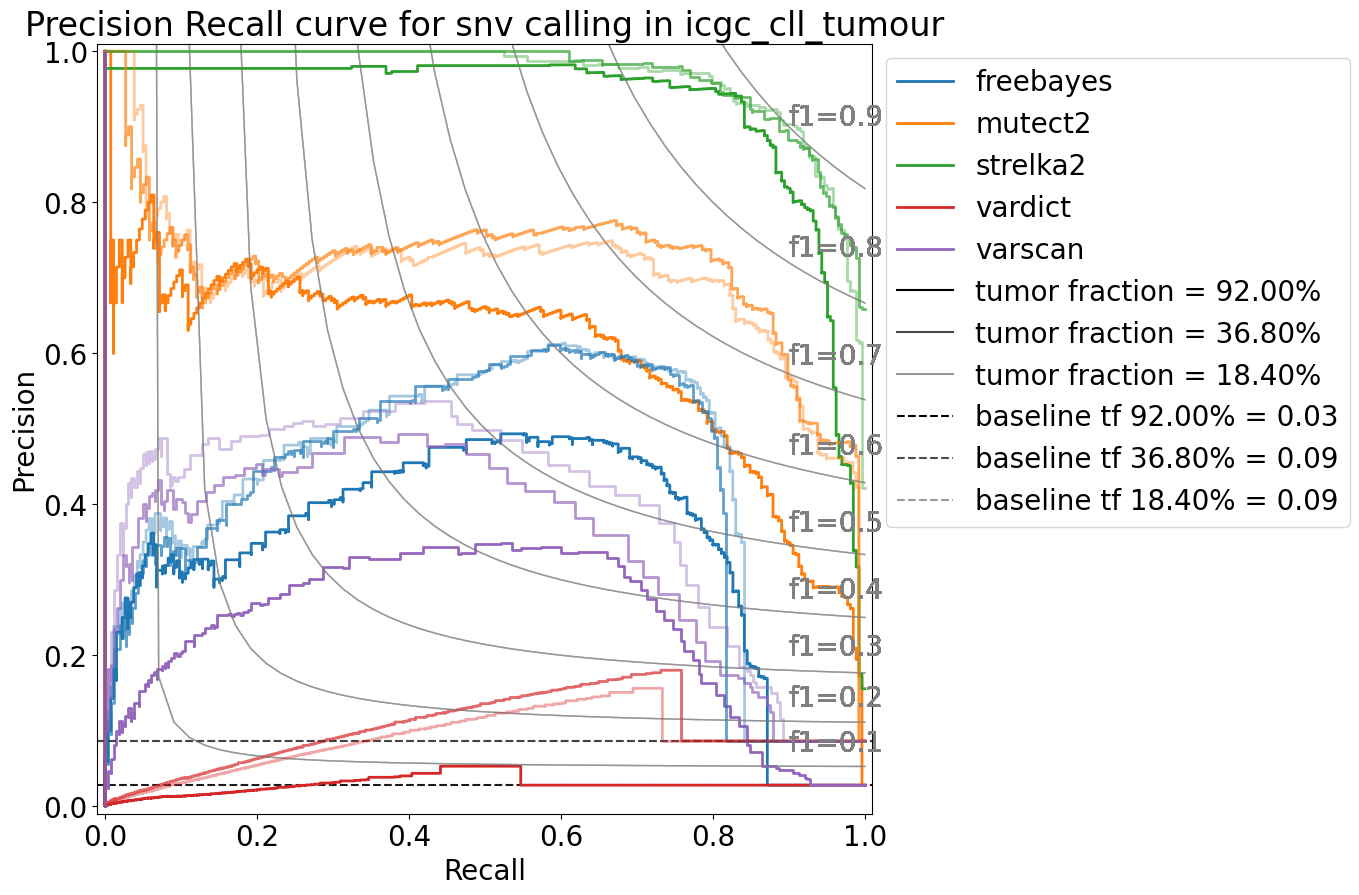

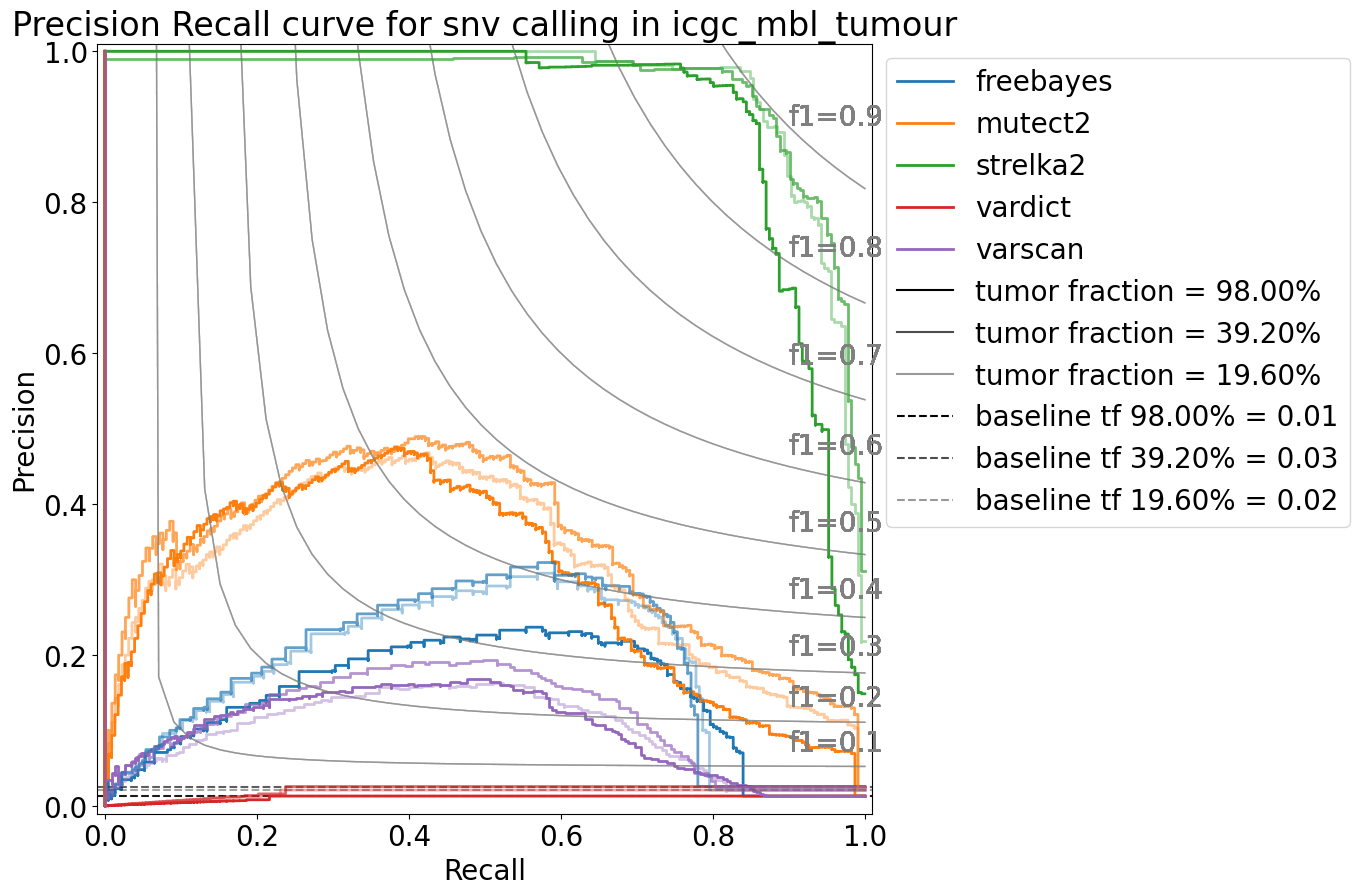

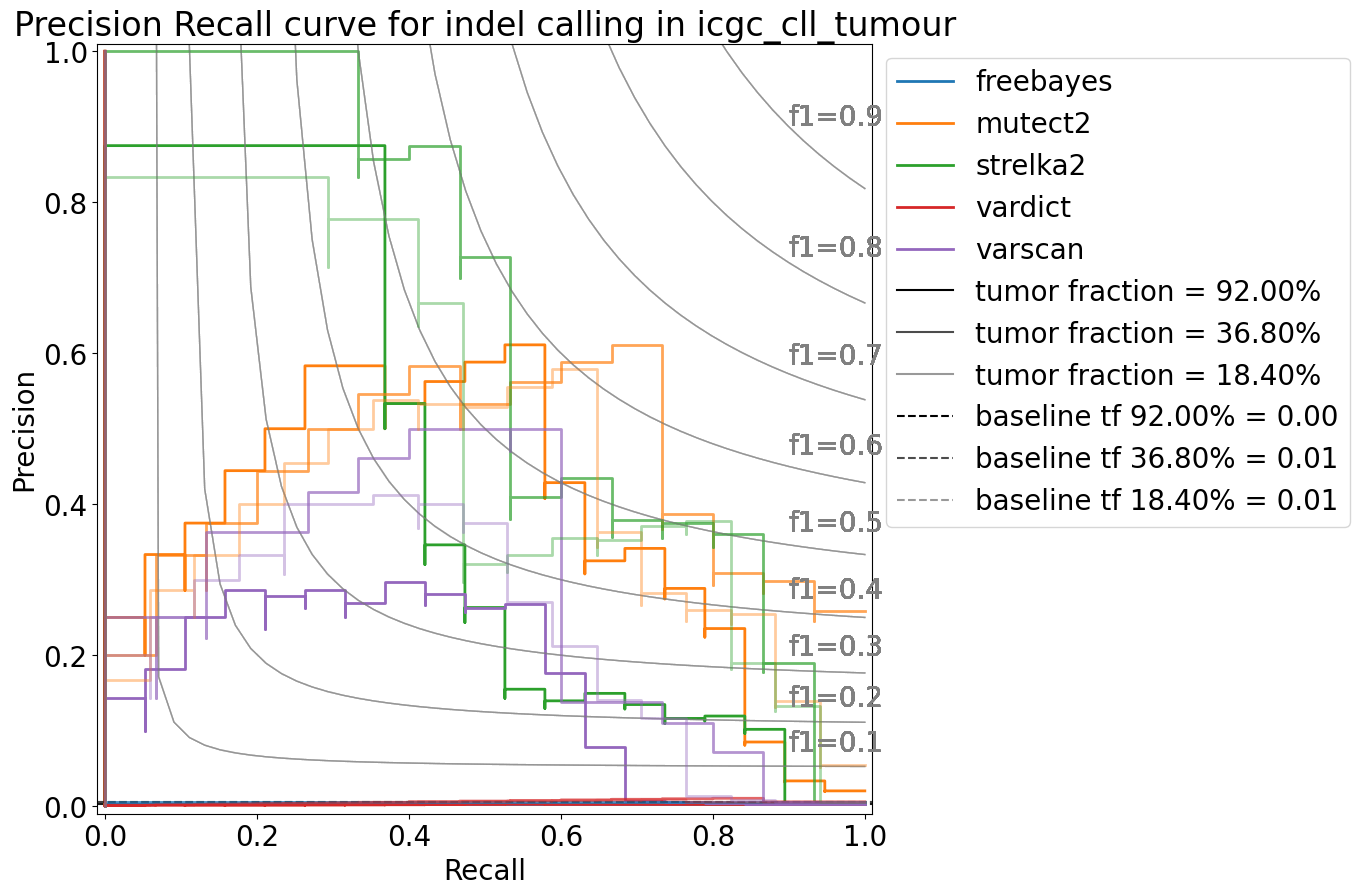

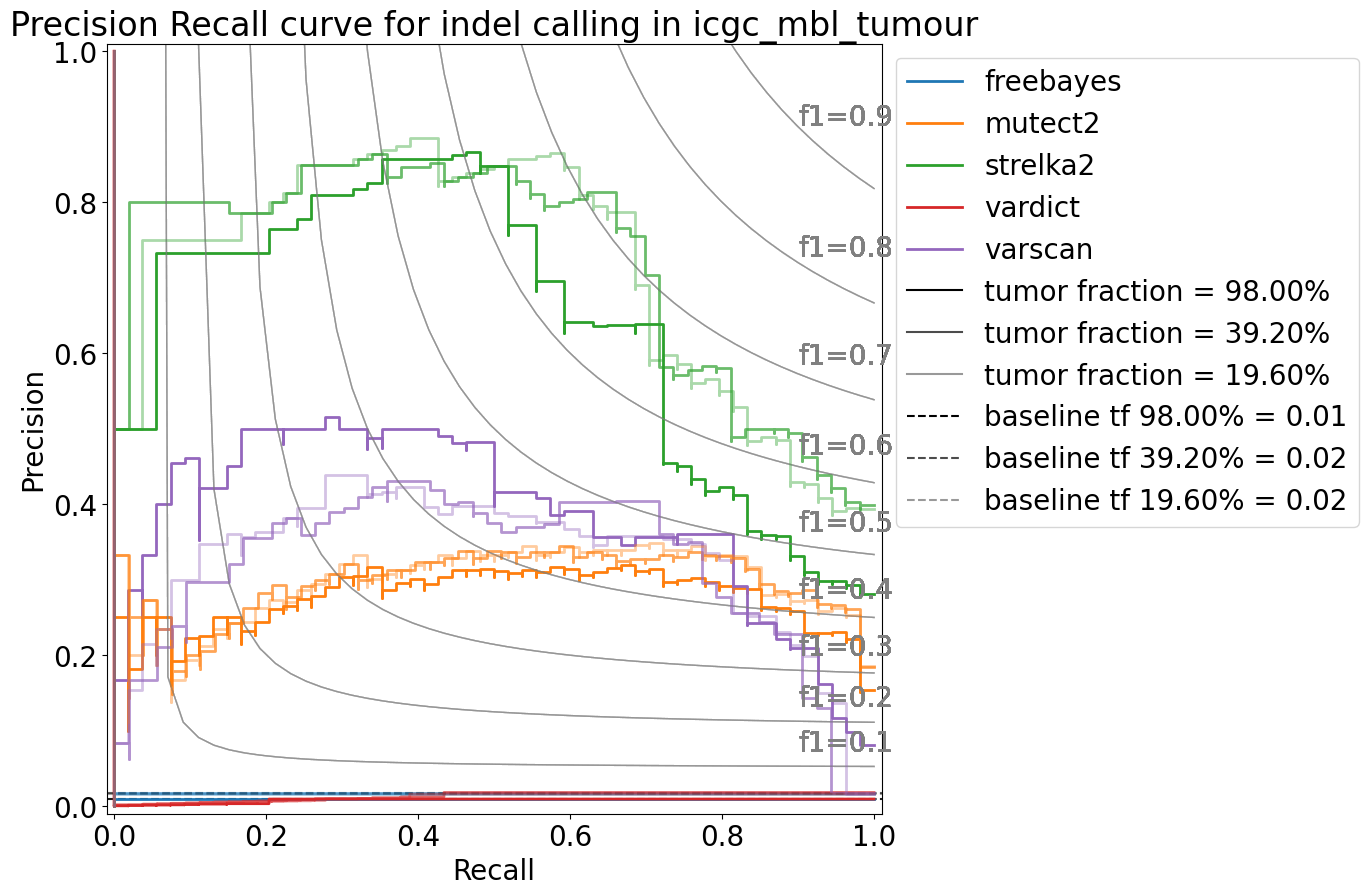

In [4]:
for muttype in ['snv', 'indel']:
    if muttype == 'snv':
        vcf_path = os.path.join(*config.tissuebenchmark, "snv-smurf-test20-v7-new5-maxdepth-2.tsv")
    elif muttype == 'indel':
        vcf_path = os.path.join(*config.tissuebenchmark, "indel-smurf-test20-v7-new5-maxdepth-2.tsv")
    vcf_samples = pd.read_csv(vcf_path, sep='\t')
    alpha_dict = {'icgc_cll_tumour': 1, "icgc_cll_T40_tumour": 0.7, 'icgc_cll_T20_tumour': 0.4}
    baseline_dict = {}

    for sample in samples:
        print(sample)
        sample_fractions = ['_'.join(sample.split('_')[:-1]) + f + '_'+ sample.split('_')[-1] for f in fraction_list]
        alpha_dict = {sample_fractions[i]: 1-0.3*i for i in range(len(fraction_list))}
        fig, ax = plt.subplots(figsize=(10,10))
        for i, s in enumerate(sample_fractions):
            print(s)
            vcf_sample = vcf_samples[vcf_samples['Sample_Name'] == s]
            vcf_sample.reset_index(inplace=True)
            vcf_sample['CHROM_POS'] = vcf_sample['X.CHROM'].astype('str').str.cat(vcf_sample['POS'].astype('str'), sep="_")
            vcf_sample.set_index('CHROM_POS', inplace=True)
            vcf_sample['mutect2_score'] = vcf_sample['m2_TLOD']
            vcf_sample['freebayes_score'] = vcf_sample['f_ODDS']
            vcf_sample['strelka2_score'] = vcf_sample['s2_SomaticEVS']
            vcf_sample['varscan_score'] = vcf_sample['vs_SSC']
            vcf_sample['vardict_score'] = vcf_sample['vd_SSF']
            print(vcf_sample[vcf_sample.index.duplicated()])
            baseline_dict[s] = len(vcf_sample['TRUTH'][vcf_sample['TRUTH']])/len(vcf_sample['TRUTH'])
            plt.axhline(y=baseline_dict[s], c='k', ls='--', alpha=alpha_dict[s])

            for method in config.methods:
                df_sample_method = vcf_sample[[method+'_score', 'TRUTH']]
                df_sample_method[method + '_score'].fillna(0, inplace=True)

                precision, recall, thresholds = precision_recall_curve(df_sample_method['TRUTH'], df_sample_method[method + '_score'])
                f1 = f1_score(vcf_sample['TRUTH'], vcf_sample['FILTER_'+method[0].upper()+method[1:]])
                if i == 0:
                    plot_pr_curve(precision, recall, estimator_name=method, f1_score=None, figax=(fig, ax), kwargs={'color':color_dict[method], 'alpha':alpha_dict[s], 'lw':2})
                else:
                    plot_pr_curve(precision, recall, estimator_name='', f1_score=None, figax=(fig, ax), kwargs={'color':color_dict[method], 'alpha':alpha_dict[s], 'lw':2})

        handles, labels = plt.gca().get_legend_handles_labels()
        list_lines = [Line2D([0], [0], color='black', alpha=alpha_dict[sample_fractions[i]], label='tumor fraction = {:.2f}%'.format(100*purity_dict[sample]*f_list[i])) for i in range(len(sample_fractions))]
        legend_list = handles + list_lines + [Line2D([0], [0], color='black', ls='--', alpha=alpha_dict[sample_fractions[i]], label="baseline tf {:.2f}% = {:.2f}".format(100*purity_dict[sample]*f_list[i], baseline_dict[sample_fractions[i]])) for i in range(len(sample_fractions))]
        # Creating legend with color box
        plt.legend(bbox_to_anchor=(1, 1), loc="upper left", handles=legend_list)
        plt.title("Precision Recall curve for {} calling in {}".format(muttype, sample))
        #plt.loglog()
        plt.xlim([-0.01, 1.01])
        plt.ylim([-0.01, 1.01])
        #plt.savefig('figures/tissue_benchmark/'+sample+'_'+muttype+'_prcurve',  bbox_inches='tight')

In [34]:
baseline_dict

{'icgc_cll_tumour': 0.02785368929997898,
 'icgc_cll_T40_tumour': 0.08659029649595687,
 'icgc_cll_T20_tumour': 0.08573320092684542,
 'icgc_mbl_tumour': 0.013423208786100297,
 'icgc_mbl_T40_tumour': 0.02603315433107635,
 'icgc_mbl_T20_tumour': 0.021406145942346112}

# AUPRC plots


In [39]:
vcf_sample.columns

Index(['index', 'X.CHROM', 'POS', 'END_POS_REF', 'REF', 'ALT', 'REF_MFVdVs',
       'ALT_MFVdVs', 'Sample_Name', 'FILTER_Mutect2', 'FILTER_Freebayes',
       'FILTER_Vardict', 'FILTER_Varscan', 'FILTER_Strelka2', 'm2_MQ',
       'm2_MQRankSum', 'm2_TLOD', 'm2_NLOD', 'm2_FS', 'm2_ReadPosRankSum',
       'm2_BaseQRankSum', 'm2_ClippingRankSum', 'f_MQM', 'f_MQMR', 'f_GTI',
       'f_LEN', 'f_ODDS', 'vs_SSC', 'vs_SPV', 'vs_GPV', 'vs_SS', 'vd_SSF',
       'vd_MSI', 'vd_SOR', 's2_QSS', 's2_MQ', 's2_SomaticEVS',
       's2_ReadPosRankSum', 'Alt_Allele_Freq', 'N_refDepth', 'N_altDepth',
       'T_refDepth', 'T_altDepth', 'relcov', 'TRUTH', 'predict', 'FALSE.',
       'TRUE.', 'mutect2_score', 'freebayes_score', 'strelka2_score',
       'varscan_score', 'vardict_score'],
      dtype='object')

icgc_cll_tumour
icgc_mbl_tumour
0.013423208786100297
0.013423208786100297
0.013423208786100297
0.013423208786100297
0.013423208786100297
icgc_mbl_T40_tumour
0.02603315433107635
0.02603315433107635
0.02603315433107635
0.02603315433107635
0.02603315433107635
icgc_mbl_T20_tumour
0.021406145942346112
0.021406145942346112
0.021406145942346112
0.021406145942346112
0.021406145942346112
icgc_mbl_tumour
icgc_mbl_tumour
0.013423208786100297
0.013423208786100297
0.013423208786100297
0.013423208786100297
0.013423208786100297
icgc_mbl_T40_tumour
0.02603315433107635
0.02603315433107635
0.02603315433107635
0.02603315433107635
0.02603315433107635
icgc_mbl_T20_tumour
0.021406145942346112
0.021406145942346112
0.021406145942346112
0.021406145942346112
0.021406145942346112
icgc_cll_tumour
icgc_mbl_tumour
0.009425728748472683
0.009425728748472683
0.009425728748472683
0.009425728748472683
0.009425728748472683
icgc_mbl_T40_tumour
0.018107277075503928
0.018107277075503928
0.018107277075503928
0.01810727707550

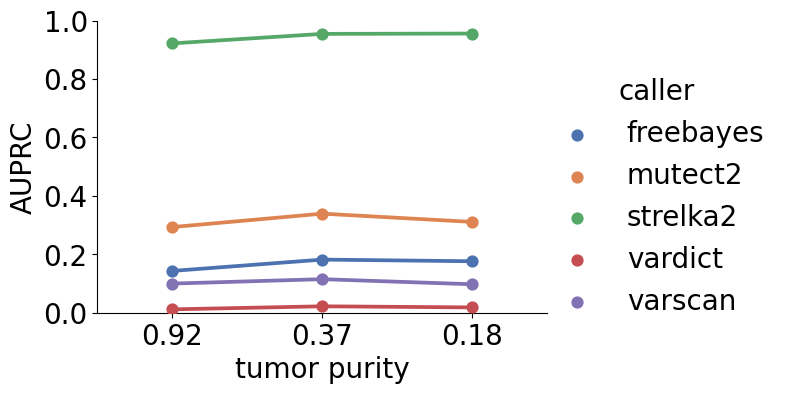

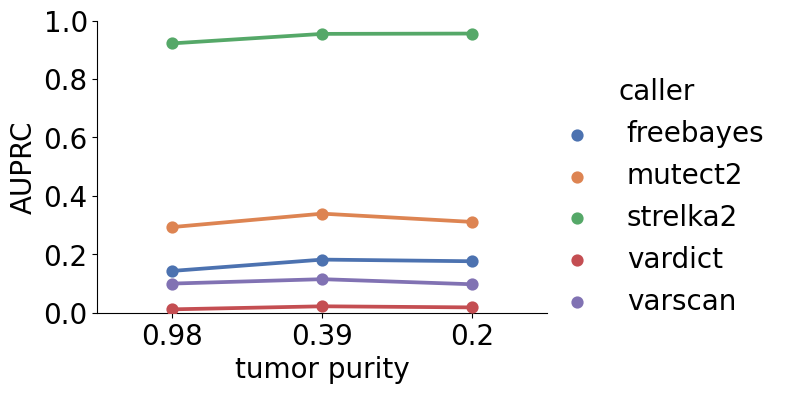

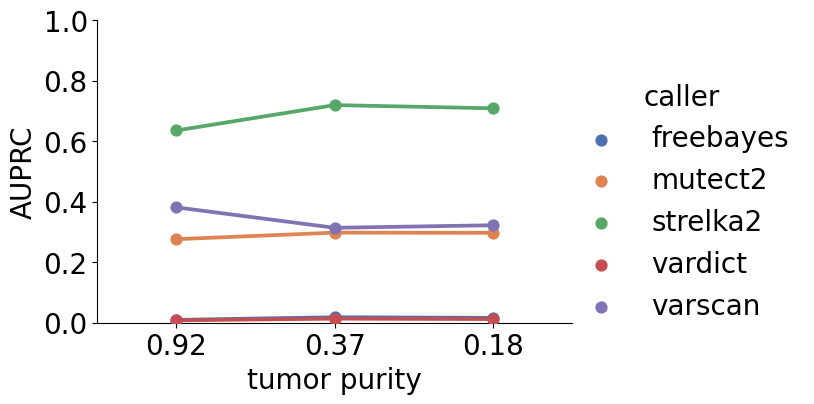

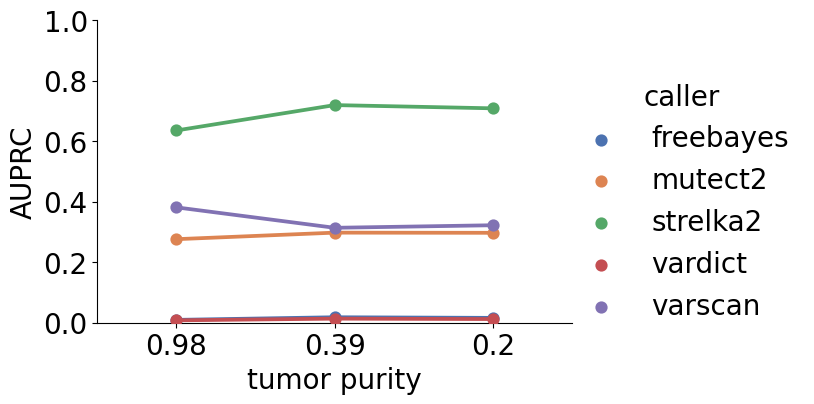

In [5]:
for muttype in ['SNV', 'INDEL']:
    if muttype == 'SNV':
        vcf_path = os.path.join(*config.tissuebenchmark, "snv-smurf-test20-v7-new5-maxdepth-2.tsv")
    elif muttype == 'INDEL':
        vcf_path = os.path.join(*config.tissuebenchmark, "indel-smurf-test20-v7-new5-maxdepth-2.tsv")
    vcf_samples = pd.read_csv(vcf_path, sep='\t')

    results_df = pd.DataFrame()
    aux_auprc = []
    aux_method = []
    aux_sample = []
    aux_tp = []
    #aux_auprcrelative = []

    for sample in samples:
        print(sample)
        for i, s in enumerate(sample_fractions):
            print(s)
            vcf_sample = vcf_samples[vcf_samples['Sample_Name'] == s]
            vcf_sample.reset_index(inplace=True)
            vcf_sample['CHROM_POS'] = vcf_sample['X.CHROM'].astype('str').str.cat(vcf_sample['POS'].astype('str'), sep="_")
            vcf_sample.set_index('CHROM_POS', inplace=True)
            vcf_sample['mutect2_score'] = vcf_sample['m2_TLOD']
            vcf_sample['freebayes_score'] = vcf_sample['f_ODDS']
            vcf_sample['strelka2_score'] = vcf_sample['s2_SomaticEVS']
            vcf_sample['varscan_score'] = vcf_sample['vs_SSC']
            vcf_sample['vardict_score'] = vcf_sample['vd_SSF']

            for method in config.methods:
                df_sample_method = vcf_sample[[method+'_score', 'TRUTH']]
                df_sample_method[method + '_score'].fillna(0, inplace=True)
                print(len(df_sample_method['TRUTH'][df_sample_method['TRUTH']])/len(df_sample_method['TRUTH']))
                auprc = average_precision_score(df_sample_method['TRUTH'], df_sample_method[method+'_score']) #- len(df_sample_method['TRUTH'][df_sample_method['TRUTH']])/len(df_sample_method['TRUTH'])
                aux_auprc.append(auprc)
                # aux_auprcrelative.append(auprc / baseline_dict[s])
                aux_method.append(method)
                aux_sample.append(sample)
                aux_tp.append(round(purity_dict[sample]*f_list[i], 2))

    results_df['AUPRC'] = aux_auprc
    #results_df['AUPRC - baseline'] = aux_auprcrelative
    results_df['tumor purity'] = aux_tp
    results_df['caller'] = aux_method
    results_df['sample'] = aux_sample

    #for si, sample in enumerate(samples):
    #    sns.catplot(x="tumor purity", y="AUPRC - baseline", hue="caller",
    #              capsize=.2, height=4, aspect=1.5, kind="point",
    #                order=sorted(results_df[results_df['sample'] == sample]['tumor purity'].unique(), reverse=True),
    #                    data=results_df[results_df['sample'] == sample])
    #    #plt.ylim([0, 1])
    #    plt.title('SNV AUPRC w.r.t. tumor purity in sample {}'.format(sample))


    for si, sample in enumerate(samples):
        sns.catplot(x="tumor purity", y="AUPRC", hue="caller",
                  capsize=.2, height=4, aspect=1.5, kind="point",
                    order=sorted(results_df[results_df['sample'] == sample]['tumor purity'].unique(), reverse=True),
                        data=results_df[results_df['sample'] == sample])
        #plt.axhline(y = baselineAUPRC, color = 'w', linestyle = '--', label='baseline AUPRC') 
        plt.ylim([0, 1])
        # plt.title(muttype+' AUPRC w.r.t. tumor purity in {}'.format(sample))

## Indel

In [29]:
vcf_sample.columns

Index(['index', 'X.CHROM', 'POS', 'END_POS_REF', 'REF', 'ALT', 'REF_MFVdVs',
       'ALT_MFVdVs', 'Sample_Name', 'FILTER_Mutect2', 'FILTER_Freebayes',
       'FILTER_Vardict', 'FILTER_Varscan', 'FILTER_Strelka2', 'm2_MQ',
       'm2_MQRankSum', 'm2_TLOD', 'm2_NLOD', 'm2_FS', 'm2_ReadPosRankSum',
       'm2_BaseQRankSum', 'm2_ClippingRankSum', 'f_MQM', 'f_MQMR', 'f_GTI',
       'f_LEN', 'f_ODDS', 'vs_SSC', 'vs_SPV', 'vs_GPV', 'vs_SS', 'vd_SSF',
       'vd_MSI', 'vd_SOR', 's2_QSS', 's2_MQ', 's2_SomaticEVS',
       's2_ReadPosRankSum', 'Alt_Allele_Freq', 'N_refDepth', 'N_altDepth',
       'T_refDepth', 'T_altDepth', 'relcov', 'TRUTH', 'predict', 'FALSE.',
       'TRUE.', 'mutect2_score', 'freebayes_score', 'strelka2_score',
       'varscan_score', 'vardict_score'],
      dtype='object')

In [27]:
vcf_path = os.path.join(*config.tissuebenchmark, "indel-smurf-test20-v7-new5-maxdepth-2.tsv")
vcf_samples = pd.read_csv(vcf_path, sep='\t')
alpha_dict = {'icgc_cll_tumour': 1, "icgc_cll_T40_tumour": 0.8, 'icgc_cll_T20_tumour': 0.5}

results_df = pd.DataFrame()
aux_f1 = []
aux_method = []
aux_sample = []
aux_tp = []

for sample in samples:
    print(sample)
    for i, s in enumerate(sample_fractions):
        print(s)
        vcf_sample = vcf_samples[vcf_samples['Sample_Name'] == s]
        vcf_sample.reset_index(inplace=True)
        vcf_sample['CHROM_POS'] = vcf_sample['X.CHROM'].astype('str').str.cat(vcf_sample['POS'].astype('str'), sep="_")
        vcf_sample.set_index('CHROM_POS', inplace=True)
        vcf_sample['mutect2_score'] = vcf_sample['m2_TLOD']
        vcf_sample['freebayes_score'] = vcf_sample['f_ODDS']
        vcf_sample['strelka2_score'] = vcf_sample['s2_SomaticEVS']
        vcf_sample['varscan_score'] = vcf_sample['vs_SSC']
        vcf_sample['vardict_score'] = vcf_sample['vd_SSF']

        for method in config.methods:
            df_sample_method = vcf_sample[[method+'_score', 'TRUTH']]
            df_sample_method[method + '_score'].fillna(0, inplace=True)
            f1 = f1_score(vcf_sample['TRUTH'], vcf_sample[method[0].upper()+method[1:]])
            aux_f1.append(f1)
            aux_method.append(method)
            aux_sample.append(sample)
            aux_tp.append(round(purity_dict[sample]*f_list[i], 2))
    
results_df['F1-score'] = aux_f1
results_df['tumor purity'] = aux_tp
results_df['caller'] = aux_method
results_df['sample'] = aux_sample
    
    
for si, sample in enumerate(samples):
    sns.catplot(x="tumor purity", y="F1-score", hue="caller",
              capsize=.2, height=4, aspect=1.5, kind="point",
                order=sorted(results_df[results_df['sample'] == sample]['tumor purity'].unique(), reverse=True),
                    data=results_df[results_df['sample'] == sample])
    #plt.axhline(y = baselineAUPRC, color = 'w', linestyle = '--', label='baseline AUPRC') 
    plt.ylim([0, 1])
    plt.title('Indel F1-score w.r.t. tumor purity in sample {}'.format(sample))

icgc_cll_tumour
icgc_mbl_tumour


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').